In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
# from importlib import reload


In [2]:
from cov_3X2 import *
from fisher import *

In [3]:
import torch as tc
tc_dtype = tc.float64
from scipy.special import binom,jn,loggamma
tc_device = tc.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

In [4]:
#only for python3
import importlib
reload=importlib.reload

In [5]:
from dask.distributed import Client,LocalCluster
client = Client(processes=True,threads_per_worker=8)
client

Client Scheduler: tcp://127.0.0.1:40997,Cluster Workers: 2 Cores: 16 Memory: 33.39 GB


In [6]:
def fisher_calc(params=['As'],Nx=3,dx_max=0.01,do_log=False,kappa_class=None):
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    
    cl0G=kappa_class.kappa_cl_tomo()
    cl_t=cl0G['stack'].compute()
    cov=cl_t['cov']
    kappa_class.Ang_PS.reset()
    kappa_class.do_cov=False

    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    ndim=len(params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    for p in params:
        x0=cosmo_fid[p]
        if do_log:
            x0=np.absolute(x0)
            x_vars[p]=x0**Dx
            if x0==1:
                x_vars[p]=(2.**Dx)/2. # 1**x=1
            x_vars[p]*=np.sign(cosmo_fid[p])
        else:
            x_vars[p]=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        
        models[p]={}
#         covs[p]={}
        model_derivs[p]={}
        for i in np.arange(Nx):
            cosmo_t=cosmo_fid.copy()
            cosmo_t[p]=x_vars[p][i]
            cl0G=kappa_class.kappa_cl_tomo(cosmo_params=cosmo_t)
            cl_t=cl0G['stack'].compute()
            models[p][i]=cl_t['cl']
#             covs[p][i]=cl_t['cov']
            kappa_class.Ang_PS.reset()
        model_derivs[p]=models[p][Nx-1]-models[p][0]
        if do_log:
            model_derivs[p]/=np.log(x_vars[p][Nx-1]/x_vars[p][0])
        else:
            model_derivs[p]/=(x_vars[p][Nx-1]-x_vars[p][0])
#     cov=covs[p][1]
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params:
        i2=0
        for p2 in params:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            i2+=1
        i1+=1
    print (cov_p_inv)
    out={}
    out['cov_p']=np.linalg.inv(cov_p_inv)
    out['error']=np.sqrt(np.diag(out['cov_p']))
    return out

# Power Spectrum covariance

In [7]:
#setup parameters
lmax_cl=2000
lmin_cl=2
l0=tc.arange(lmin_cl,lmax_cl,dtype=tc_dtype,device=tc_device)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=tc.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins,dtype=tc_dtype,device=tc_device).int()
l_bins=l_bins.type(tc_dtype)
lb=np.sqrt(l_bins[1:]*l_bins[:-1])

l=tc.unique(tc.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20,device=tc_device).int()) #if we want to use fewer ell
l=l.type(tc_dtype)
do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False

bin_xi=True
theta_bins=tc.logspace(np.log10(1./60),1,20)


##  Test with 1 redshift bin

In [8]:
zs_bin1=source_tomo_bins(zp=[1.],p_zp=tc.tensor([1.],dtype=tc.double),ns=26.)

26.0 tensor([1.], dtype=torch.float64) tensor([1.], dtype=torch.float64)
tensor([0, 1]) tensor([1.], dtype=torch.float64) tensor([0.9999, 1.0001])


In [8]:

import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [9]:
import binning
reload(binning)
from binning import *

In [10]:
# bin_cl=False
if not bin_cl:
    lb=l0
    l=l0

In [11]:
from astropy.cosmology import Planck15 as cosmo


In [12]:
import pyccl as ccl
cosmo_params={'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'As': 2.12e-09,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}

#from ccl
# cosmo_params=kappa0.Ang_PS.PS.cosmo_params
# cosmo = pyccl.Cosmology(Omega_c=0.2589, Omega_b=0.0486, h=0.6774, A_s=2.12e-9, n_s=0.965)
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],m_nu=[0,0,0.06])
# #this dies
# # lens1 = ccl.ClTracerLensing(cosmo, False, z=zs_bin1[0]['z'], n=zs_bin1[0]['pz'])
# z =array([1])
# pz=array([1])
# lens1 = pyccl.ClTracerLensing(cosmo, False, z=z, n=pz)
# print(z)
# ell = np.arange(2, 1000)
# cls = ccl.angular_cl(cosmo, lens1, lens1, ell)

In [13]:
#use all ell
kappa0=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=None,#z_PS_max=1087,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,)#f_sky=0.35,sigma_gamma=0.37)

#use only subsampled ell (faster, less accurate)
kappa1=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l,zg_bins=None,#np.int32((l[1:]+l[:-1])*0.5),
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,)#z_PS_max=1087,)#f_sky=0.35)

# ell are different in kappa0 and kappa1. To test if we can get aways with computation at fewer l, when binning
# with l_bins. Remeber, cl and cov are computed at some l first and then binned.

In [14]:
#get compute graphs
%time cl0G=kappa0.cl_tomo() 
#%time cl1G=kappa1.cl_tomo()
# cl0G['stack'].visualize()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
got pk
CPU times: user 22.3 s, sys: 14.2 ms, total: 22.3 s
Wall time: 2.89 s


In [15]:
%time cl0=cl0G['stack'].compute()

1 39 1
dict_keys([('shear', 'shear', 'shear', 'shear')])
CPU times: user 679 ms, sys: 70.5 ms, total: 750 ms
Wall time: 464 ms


In [16]:
#get cl and cov
# %time cl0=cl0G['stack'].compute()

# compute signal/noise
cov_inv=np.linalg.inv(cl0['cov'])
SN=np.sqrt(np.dot(cl0['cl'],np.dot(cov_inv,cl0['cl'])))
SN

232.12248

In [17]:
cl0['cl']

tensor([4.0715e-08, 3.9603e-08, 3.7992e-08, 3.5849e-08, 3.3312e-08, 3.0884e-08,
        2.8252e-08, 2.5567e-08, 2.2930e-08, 2.0443e-08, 1.8157e-08, 1.5950e-08,
        1.3914e-08, 1.1993e-08, 1.0327e-08, 8.8817e-09, 7.5376e-09, 6.3694e-09,
        5.3501e-09, 4.4741e-09, 3.7365e-09, 3.1298e-09, 2.6309e-09, 2.2096e-09,
        1.8600e-09, 1.5701e-09, 1.3316e-09, 1.1331e-09, 9.6647e-10, 8.2669e-10,
        7.0823e-10, 6.0700e-10, 5.2038e-10, 4.4556e-10, 3.8038e-10, 3.2359e-10,
        2.7410e-10, 2.3097e-10, 1.9347e-10])

In [18]:
#again get Cl and cov, this time by referencing the particular bin
cl0={}
cl1={}
corr=('shear','shear')
%time cl0['cl0']=cl0G['cl'][corr][(0,0)].compute()
%time cl0['cl']=cl0G['cl_b'][corr][(0,0)].compute()
%time cl0['cov']=cl0G['cov'][corr+corr][(0,0,0,0)].compute()#kappa0.compute_cov_tomo(cl0G['cov'])
# %time cl1['cl']=cl1G['cl_b'][corr][(0,0)].compute()
# %time cl1['cov']=cl1G['cov'][corr+corr][(0,0,0,0)].compute()#kappa1.compute_cov_tomo(cl1G['cov'])

CPU times: user 12.8 ms, sys: 51 µs, total: 12.8 ms
Wall time: 3.25 ms
CPU times: user 13.3 ms, sys: 6.77 ms, total: 20 ms
Wall time: 5.7 ms
CPU times: user 706 ms, sys: 34.2 ms, total: 740 ms
Wall time: 470 ms


In [19]:
cl_t=cl0['cl']#[(0,0)]
cl_t2=cl1['cl']#[(0,0)]
plot(lb,cl_t)
# hlines(1,1,2000)
xscale('log')
yscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$')

show()
plot(lb,cl_t/cl_t2)
hlines(1,1,2000)
xscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$ Ratio')
# ylim(8e-7,8.6e-7)
# yscale('log')

KeyError: 'cl'

In [ ]:
cov0=cl0['cov']#[(0,0,0,0)]
f=1e4
plot(np.array(lb),np.array(cov0['G'].diag()/cl_t**2*f),label='Gaussian')
#plot(lb,np.diag(cov02['G'])/cl_t**2*f*0.95)
plot(np.array(lb),np.array(cov0['SSC'].diag()/cl_t**2*f),label='SSC')
# plot(lb,np.diag(cov0['SSC_dk'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(10,3000)
xlabel(r'$\ell$')
ylabel(r'$\frac{\delta C_\ell}{C_\ell^2}\times'+str(f)+'$')
legend()

In [ ]:
cov0=cl0['cov']#[(0,0,0,0)]
corr2=kappa0.cov_utils.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
# xlim(lmin_clB,lmax_clB)
# ylim(lmin_clB,lmax_clB)
xlabel(r'$\ell$')
ylabel(r'$\ell$')

##  Test with multiple redshift bins (Tomography)

In [20]:
import lensing_utils
reload(lensing_utils)

import lsst_utils
reload(lsst_utils)
from lsst_utils import *

import lensing_lensing
reload(lensing_lensing)

from lensing_lensing import *



In [21]:
#Setup redshift bins
zmin=0.3
zmax=2

z=tc.linspace(0,5,200,dtype=tc.double)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26#+np.inf #ns=inf means shape noise is zero
nbins=3  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=tc.zeros_like(z
                                                                                 ),
                        zp_sigma=z_sigma*np.ones_like(z))

# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

do_cov=True
bin_cl=True
SSV_cov=True
tidal_SSV=False

In [22]:
pzs.dtype

torch.float64

In [23]:
kappaS = cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=False,
               bin_xi=bin_xi)#ns=np.inf)

# kappaL = Kappa(zs_bins=zl_bins,l=l0,cross_PS=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [24]:
%time clSG=kappaS.cl_tomo()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
got pk
CPU times: user 15.9 s, sys: 6.25 ms, total: 15.9 s
Wall time: 2.53 s


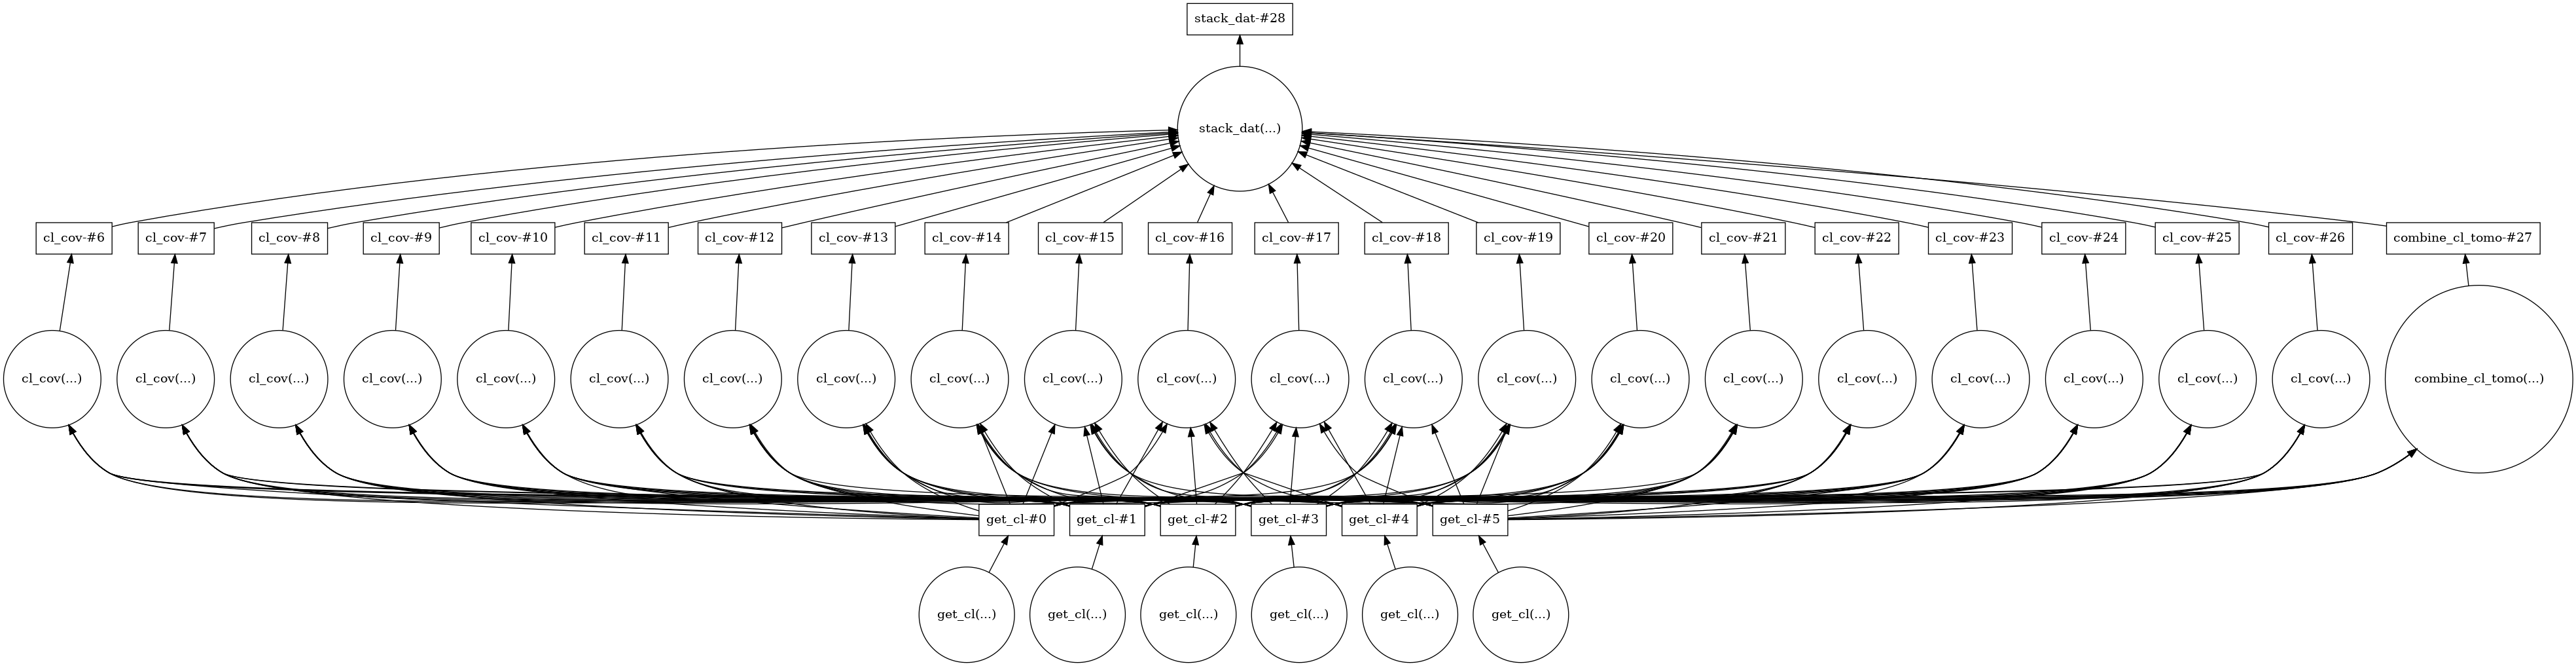

In [26]:
clSG['stack'].visualize() #compute graph

In [27]:
%time clS=clSG['stack'].compute()

6 39 1
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'shear')])
dict_keys([('shear', 'shear', 'shear', 'she

In [28]:
# np.diag(kappaL.lensing_utils.SN[0]),
np.diag(kappaS.lensing_utils.SN[0])

array([7.99877688e-10, 1.04992210e-09, 1.85625649e-09])

Text(0,0.5,'$p(z)$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
02:44:31 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
02:44:31 INFO:findfont: Found a missing font file.  Rebuilding cache.
02:44:31 INFO:font search path ['/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
02:44:31 DEBUG:trying fontname /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf
02:44:31 DEBUG:trying fontname /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf
02:44:31 DEBUG:trying

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmuibx6.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/xits/xits-regular.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/bh/gofonts/GoMono-Regular-Italic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/huerta/caladea/Caladea-Italic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozit7.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/lm/lmsansquot8-boldoblique.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoz11.otf
02:44:31 DEBUG:trying fontname /usr/share/fonts/TTF/MuktiNarrowBold.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozitbx7.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/catharsis/cormorantgaramond/CormorantGaramond-SemiBold.otf
02:44:31 DEBUG:tryi

02:44:31 DEBUG:trying fontname /usr/share/fonts/TTF/VeraMoBI.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/libertinus/libertinusserif-semibold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/google/noto/NotoSerif-SemiBold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexSerif-Thin.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozb8.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/raleway/Raleway-Bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmscbx7.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/cm-unicode/cmunbtl.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/librecaslon/LibreCaslonText-Bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/xcharter/XCharter-BoldSlanted.otf
02:44:31 

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/phaistos/Phaistos.otf
02:44:31 DEBUG:trying fontname /usr/share/fonts/gsfonts/URWBookman-LightItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmb11.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/xcharter/XCharter-Roman.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/rosario/Rosario-BoldItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/montserrat/MontserratAlternates-Medium.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltltsemicond-regular.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoz17.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/lm/lmroman5-bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmitsc14.otf
02:44:31 

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/montserrat/Montserrat-BlackItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drml8.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/iginomarini/imfellenglish/IMFeENrm28P.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/dejavu/DejaVuSansMono-Bold.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/gentium-tug/GentiumPlusCompact-R.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexSansCondensed-Text.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/arkandis/mintspirit/MintSpiritNo2-Regular.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexSans-BoldItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltltsemicond-bold.otf
02:44:31 DEBUG:trying fontname /usr

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/huerta/caladea/Caladea-BoldItalic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/umtypewriter/UMTypewriter-BoldItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/sorkin/merriweather/Merriweather-Bold.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/librecaslon/LibreCaslonText-Regular.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/huerta/alegreya/Alegreya-BoldItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/montserrat/MontserratAlternates-Light.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmittc12.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltltsemiexpd-bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/cm-unicode/cmunbso.otf
02:44:31 DEBUG:trying fo

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/librebaskerville/LibreBaskerville-BoldItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/lobster2/LobsterTwo-Bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/google/roboto/Roboto-Light.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmsym10.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fetamont/ffmlqo10.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fonts-churchslavonic/MonomakhUnicode.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/tempora/Tempora-Bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/lm/lmsans9-oblique.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/nowacki/iwona/Iwona-Regular.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opent

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexSans-Bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/antt/AntykwaTorunskaCond-BoldItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/google/noto/NotoSans-LightItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fira/FiraMono-Bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexSansCondensed-Regular.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpolt-italic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/dejavu/DejaVuSansMono-Oblique.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/adobe/sourcecodepro/SourceCodePro-RegularIt.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/arkandis/berenisadf/BerenisADFPro-BoldItalic.otf
02:44:31 DEBUG:trying fontname

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/cochineal/Cochineal-Roman.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/raleway/Raleway-Medium.otf
02:44:31 DEBUG:trying fontname /usr/share/fonts/TTF/DejaVuSerif-BoldItalic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/cm-unicode/cmunbmr.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/cm-unicode/cmunvt.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/belleek/rblmi.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fira/FiraSans-Heavy.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/dejavu/DejaVuSerifCondensed-Italic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/muhafara/overlock/OverlockSC-Regular.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/google/arimo/Arimo-Regular.ttf
02

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/lm/lmsans12-oblique.otf
02:44:31 DEBUG:trying fontname /usr/share/fonts/TTF/DejaVuSerif-Bold.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltsemicond-bolditalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/omnibus-type/asapsym/Asap-Symbol.otf
02:44:31 DEBUG:trying fontname /usr/share/fonts/TTF/DroidNaskh-Bold.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fetamont/ffmb10.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/sorkin/merriweather/Merriweather-UltraBdIt.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/lm-math/latinmodern-math.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozittc6.otf
02:44:31 DEBUG:trying f

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/muhafara/overlock/Overlock-Bold.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozl11.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmtcbx11.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/lm/lmmonocaps10-regular.otf
02:44:31 DEBUG:trying fontname /usr/share/fonts/TTF/LiberationSerif-BoldItalic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoztcbx10.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/nowacki/kurier/Kurier-Italic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/arkandis/gillius/GilliusADFCond-Bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozbx6.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/dejavu/DejaVuSerifCondensed-Bold.ttf
02:44:31 DEBU

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozscbx24.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/opensans/OpenSans-CondLight.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/google/noto/NotoMono-Regular.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/google/tinos/Tinos-BoldItalic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltltexpd-italic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozit11.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/tex-gyre-math/texgyreschola-math.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/montserrat/MontserratAlternates-Black.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/adobe/sourcecodepro/SourceCodePro-Semibold.otf
02:44:31 DEBUG:trying fontname /usr/share/fonts/

02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/cm-unicode/cmuntb.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmtcbx12.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/cabin/CabinCondensed-Medium.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fetamont/ffmo9.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/junicode/Junicode-Italic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltltexpd-bold.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/gnu-freefont/FreeSerifItalic.ttf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fira/FiraSans-Medium.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexSans-MediumItalic.otf
02:44:31 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fetamon

02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/adobe/sourcesanspro/SourceSansPro-RegularIt.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/fontawesome5/FontAwesome5Free-Regular-400.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmitsc24.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/quattrocento/QuattrocentoSans-Italic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/kosch/crimson/Crimson-Italic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/huerta/caladea/Caladea-Regular.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/frederika2016/Frederika2016.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/tex-gyre/texgyreadventor-italic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/academicons/academicons.ttf
02:44:32 DEBUG:trying font

02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/semaphor/smfbsl10.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/playfair/PlayfairDisplay-Bold.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/libertine/LinLibertine_MB.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/adobe/sourceserifpro/SourceSerifPro-Light.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/adobe/sourcecodepro/SourceCodePro-Medium.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmsl12.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltcond-bold.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/rosario/Rosario-Italic.otf
02:44:32 DEBUG:trying fontname /usr/share/fonts/cantarell/Cantarell-ExtraBold.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/montserr

02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/nowacki/kurier/Kurier-BoldItalic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/cochineal/Cochineal-Italic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/lm/lmroman6-bold.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmsc6.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drm24.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/intel/clearsans/ClearSans-Light.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltsemiexpd-italic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/bh/gofonts/Go-Bold.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoztcbx17.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/raleway/Raleway-SemiBold-Italic.otf

02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/nowacki/kurier/KurierCondHeavy-Italic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmitbx11.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/gnu-freefont/FreeSans.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/impallari/cabin/Cabin-RegularItalic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmscbx10.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmb8.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/nowacki/iwona/IwonaCondLight-Regular.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/impallari/lobster2/LobsterTwo-Italic.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/adobe/sourcecodepro/SourceCodePro-BlackIt.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public

02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/coelacanth/CoelacanthExtraLt.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoz14.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/fonts-churchslavonic/PomorskyUnicode.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/huerta/alegreya/AlegreyaSans-BoldItalic.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexMono-Bold.otf
02:44:32 DEBUG:trying fontname /usr/share/fonts/TTF/VeraBd.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/opensans/OpenSans-LightItalic.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmitbx10.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/libertine/LinLibertine_RZI.otf
02:44:32 DEBUG:trying fontname /usr/share/fonts/TTF/DroidSansMono.ttf
02:44:32 DEBUG:trying fontname /u

02:44:32 DEBUG:trying fontname /usr/share/fonts/TTF/DroidSansTamil-Bold.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmsc12.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/drm/drmfigs11.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/typoland/lato/Lato-Regular.ttf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/public/gfsneohellenicmath/GFSNeohellenicMath.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/public/anonymouspro/AnonymousPro-Regular.ttf
02:44:32 DEBUG:trying fontname /usr/share/fonts/gsfonts/P052-Bold.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/nowacki/iwona/IwonaCondHeavy-Regular.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/opentype/huerta/alegreya/AlegreyaSans-Regular.otf
02:44:32 DEBUG:trying fontname /usr/share/texmf-dist/fonts/truetype/typoland/lato/Lato-Hairline.ttf
02:44:32 DEBUG:trying f

02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoz6.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/nimbus15/zco-BoldOblique.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/inconsolata/Inconsolatazi4-Regular.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/arkandis/berenisadf/BerenisADFProSC-Regular.otf
02:44:32 DEBUG:createFontDict: /usr/share/fonts/TTF/LiberationSans-Regular.ttf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/umtypewriter/UMTypewriter-Oblique.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmit6.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/algolrevived/AlgolRevived.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/cochineal/Cochineal-BoldItalic.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm

02:44:32 DEBUG:createFontDict: /usr/share/fonts/gsfonts/P052-Italic.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/comfortaa/Comfortaa-Light.ttf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/fira/FiraSans-Regular.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/impallari/cabin/Cabin-Regular.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexSerif-TextItalic.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/impallari/librebodoni/LibreBodoni-BoldItalic.otf
02:44:32 DEBUG:createFontDict: /usr/share/fonts/TTF/mal2-n.ttf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/beuron/BeuronCondensed-Regular.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/ccicons/ccicons.otf
02:44:32 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/beuron/Beuron-Regular.otf
02:44:32 DEBUG:createFontDict

02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexMono-BoldItalic.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/lm/lmsansquot8-oblique.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/fetamont/ffmho8.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/arkandis/universalis/UniversalisADFStd-Regular.otf
02:44:33 DEBUG:createFontDict: /usr/share/fonts/gsfonts/NimbusSansNarrow-BdOblique.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmui14.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/montserrat/MontserratAlternates-Thin.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/nimbus15/ztm-Reg.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/tex-gyre/texgyreheros-bold.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/gnu-freef

02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/semaphor/smfpbsl10.otf
02:44:33 DEBUG:createFontDict: /usr/share/fonts/TTF/DroidSansJapanese.ttf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/gfsdidot/GFSDidotItalic.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/google/noto/NotoSans-ThinItalic.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozscbx9.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/erewhon/Erewhon-BoldItalic.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozl8.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/adobe/sourceserifpro/SourceSerifPro-Bold.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/fontmfizz/font-mfizz.ttf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltexpd-regular.otf
02:44:33

02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozsl7.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoztc10.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/arkandis/accanthis/AccanthisADFStdNo3-Regular.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/impallari/raleway/Raleway-Light.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/impallari/raleway/Raleway-ExtraBold-Italic.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/fetamont/ffmr8.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/paratype/ptsans/PTS56F.ttf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/huerta/alegreya/Alegreya-ExtraBold.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/lm/lmsansdemicond10-regular.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/publi

02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/google/noto/NotoSerif-ExtraBold.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/rozynski/comicneue/ComicNeue-Angular_Bold.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/gnu-freefont/FreeMonoOblique.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/antt/AntykwaTorunskaCond-Italic.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/cm-unicode/cmunst.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/punknova/punknova-regular.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/gentium-tug/GenBkBasBI.ttf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/stix/STIX-Regular.otf
02:44:33 DEBUG:createFontDict: /usr/share/fonts/TTF/DejaVuSansCondensed-Oblique.ttf
02:44:33 DEBUG:createFontDict: /usr/share/fonts/gsfonts/D050000L.otf
02:44:33 

02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmit17.otf
02:44:33 DEBUG:createFontDict: /usr/share/fonts/TTF/gbolilite.ttf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/gnu-freefont/FreeSerif.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/lm/lmroman9-bold.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/droid/DroidSans-Bold.ttf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozitbx17.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/fira/FiraSans-UltraLightItalic.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/nowacki/kurier/KurierCondMedium-Regular.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/fira/FiraSans-ExtraBoldItalic.otf
02:44:33 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/belleek/blsy.ttf
02:44:33 DEBUG:createFontD

02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozb14.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/ocr-b-outline/ocrb8.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/google/roboto/RobotoSlab-Bold.ttf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/almfixed/almfixed.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/rozynski/comicneue/ComicNeue-Angular_Regular_Oblique.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoztc9.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/arkandis/mintspirit/MintSpirit-BoldItalic.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/shobhika/Shobhika-Regular.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/lm/lmmono10-regular.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/publi

02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/impallari/cabin/Cabin-BoldItalic.otf
02:44:34 DEBUG:createFontDict: /usr/share/fonts/TTF/DejaVuSerifCondensed-Italic.ttf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozuibx9.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/gentium-tug/GentiumPlus-R.ttf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/muhafara/overlock/Overlock-Black.ttf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/cm-unicode/cmunsi.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/paratype/ptserif/PTF56F.ttf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/impallari/raleway/Raleway-Black-Italic.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmsym14.otf
02:44:34 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozuibx11.otf
02:44:34 DEBUG

02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/tex-gyre/texgyreadventor-italic.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/academicons/academicons.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/antt/AntykwaTorunskaCondMed-Regular.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/lm/lmsansquot8-regular.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/paratype/ptsans/PTC55F.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/droid/DroidSansMono.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/fetamont/ffmr10.otf
02:44:35 DEBUG:createFontDict: /usr/share/fonts/gsfonts/Z003-MediumItalic.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/impallari/quattrocento/Quattrocento-BoldItalic.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmu

02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/rosario/Rosario-Italic.otf
02:44:35 DEBUG:createFontDict: /usr/share/fonts/cantarell/Cantarell-ExtraBold.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/montserrat/MontserratAlternates-BlackItalic.otf
02:44:35 DEBUG:createFontDict: /usr/share/fonts/TTF/DejaVuSans-Oblique.ttf
02:44:35 DEBUG:createFontDict: /usr/share/fonts/TTF/DejaVuSerif.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/newtx/TeXGyreTermesX-Bold.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/mnsymbol/MnSymbol-Bold7.otf
02:44:35 DEBUG:createFontDict: /usr/share/fonts/TTF/VeraSe.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/fonts-churchslavonic/IndictionUnicode.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozb12.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/n

02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/bh/gofonts/Go-Bold.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoztcbx17.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/impallari/raleway/Raleway-SemiBold-Italic.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozsl10.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/ibm/plex/IBMPlexSans-Italic.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/google/roboto/RobotoSlab-Regular.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/google/noto/NotoSans-SemiBold.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/antt/AntykwaTorunska-BoldItalic.otf
02:44:35 DEBUG:createFontDict: /usr/share/fonts/TTF/DroidSansThai.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/nowacki/iwona/IwonaHeavy-Regular.otf
02:44:35 DEB

02:44:35 DEBUG:createFontDict: /usr/share/fonts/TTF/VeraBd.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/opensans/OpenSans-LightItalic.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmitbx10.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/libertine/LinLibertine_RZI.otf
02:44:35 DEBUG:createFontDict: /usr/share/fonts/TTF/DroidSansMono.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/paratype/ptmono/PTM75F.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/lm/lmroman10-bold.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/umtypewriter/UMTypewriter-Bold.otf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/gust/poltawski/antpoltlt-italic.otf
02:44:35 DEBUG:createFontDict: /usr/share/fonts/TTF/DejaVuSans-ExtraLight.ttf
02:44:35 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/

02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/public/anonymouspro/AnonymousPro-Regular.ttf
02:44:36 DEBUG:createFontDict: /usr/share/fonts/gsfonts/P052-Bold.otf
02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/nowacki/iwona/IwonaCondHeavy-Regular.otf
02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/huerta/alegreya/AlegreyaSans-Regular.otf
02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/truetype/typoland/lato/Lato-Hairline.ttf
02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/chivo/Chivo-Light.otf
02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmuibx8.otf
02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/libertinus/libertinusserif-italic.otf
02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdozitsc17.otf
02:44:36 DEBUG:createFontDict: /usr/share/texmf-dist/fonts/opentype/public/drm/drmdoztc17.otf
02:44:3

02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm/ptmr8a.afm
02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Times-BoldItalic.afm
02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm/pncri8a.afm
02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm/phvr8a.afm
02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm/pncr8a.afm
02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm/phvb8a.afm
02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm/pbkdi8a.afm
02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm/cmtt10.afm
02:44:36 DEBUG:createFontDict: /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Courier-Oblique.afm
02:44:36 DEBUG:c

02:44:36 DEBUG:findfont: Matching :family=STIXSizeFourSym:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXSizeFourSym ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf') with score of 0.050000
02:44:36 DEBUG:findfont: Matching :family=STIXSizeFiveSym:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXSizeFiveSym ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf') with score of 0.050000
02:44:36 DEBUG:findfont: Matching :family=cmsy10:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to cmsy10 ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf') with score of 0.050000
02:44:36 DEBUG:findfont: Matching :family=cmr10:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to cmr10 ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf') with score of 0.050000
02:44:36 DEBUG:findfont: Matching :fa

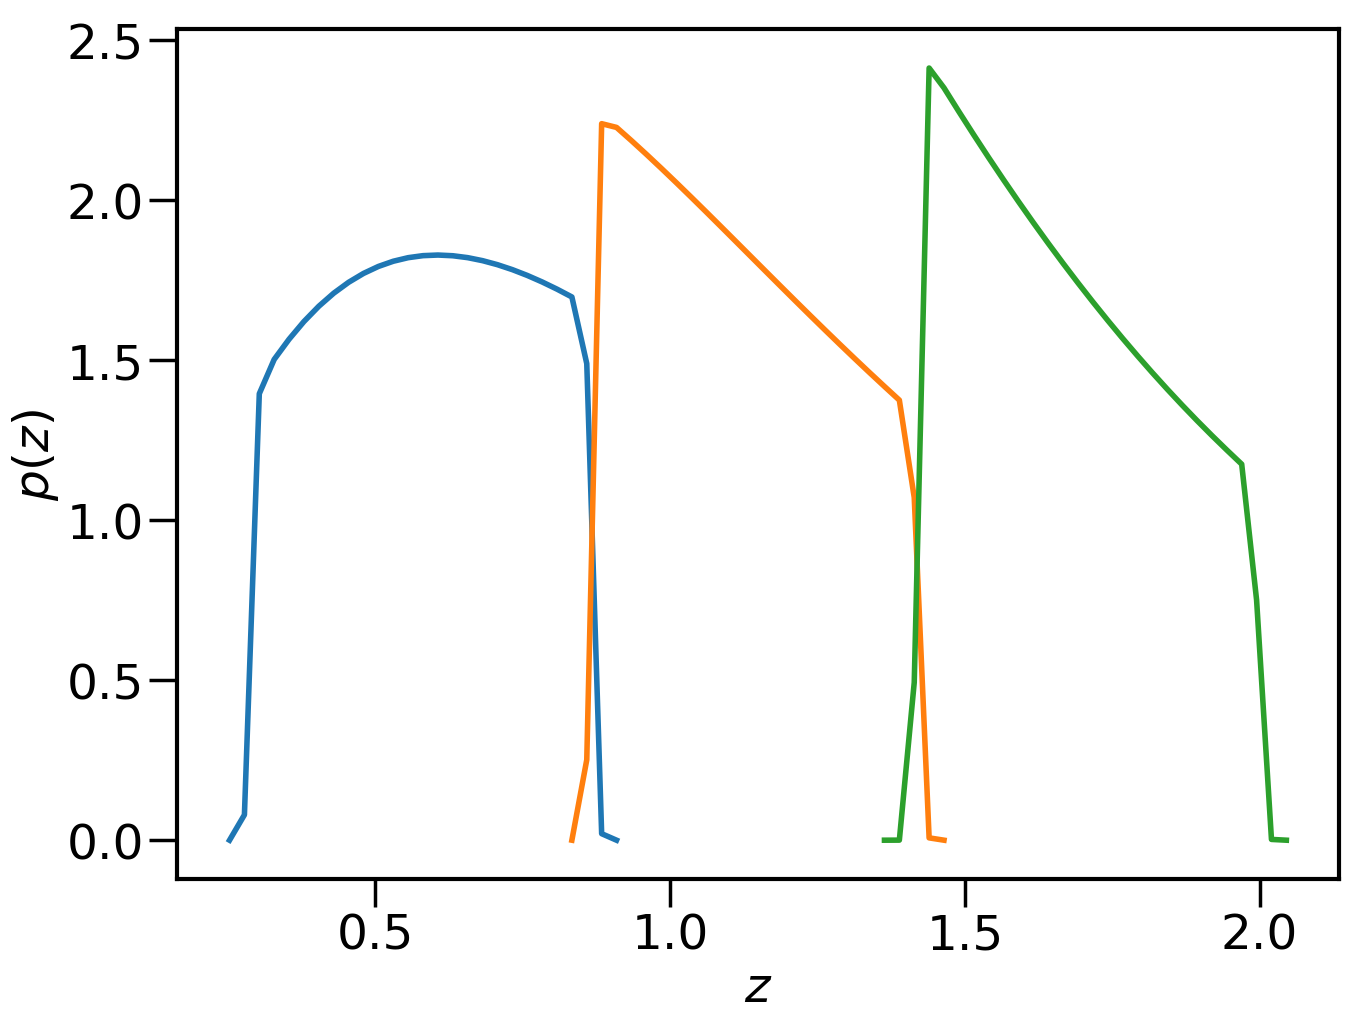

In [29]:

nb=kappaS.z_bins['shear']['n_bins']
for i in np.arange(nb):
    zb=zs_bins[i] #kappaS.zs_bins[i]
    plot(zb['z'].numpy(),zb['pz'].numpy())
#     print(np.sum(zb['nz']))
xlabel(r'$z$')
ylabel(r'$p(z)$')

In [30]:
nb=kappaS.z_bins['shear']['n_bins']
zl=kappaS.z_bins['shear']['z_lens_kernel']
for i in np.arange(nb):
    zb=kappaS.z_bins['shear'][i]
    plot(zl,zb['lens_kernel'])
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
yscale('log')
xlabel(r'$z$')
ylabel(r'Lensing Kernel')
# ylim(2.e-4,20)

KeyError: 'lens_kernel'

In [ ]:
clS['cov'].shape

In [ ]:
zs_bins[0]['Norm']

In [ ]:
covS_inv=np.linalg.inv(clS['cov'])
print (np.sqrt(np.dot(clS['cl'],np.dot(covS_inv,clS['cl']))))
# covL_inv=np.linalg.inv(clL['cov'])
# print (np.sqrt(np.dot(clL['cl'],np.dot(covL_inv,clL['cl']))))

In [ ]:
cc=kappaS.cov_utils
corrS=cc.corr_matrix(clS['cov'])
pcolor(corrS,vmin=-1,vmax=1,cmap='seismic')
xlabel(r'$\ell$')
ylabel(r'$\ell$')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
corr=('shear','shear')

In [ ]:
ell = np.arange(2, 2000)
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'])
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
#         errorbar(lb,clSG['cl_b'][corr][(i,j)].compute(),np.sqrt(np.diag(clSG['cov'][corr+corr][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
        plot(l0,clSG['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, ell)
        plot(ell,cls)
        xscale('log')
        yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
        legend()
        show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(lb,clSG['cl_b'][corr][(i,j)].compute()/np.sqrt(np.diag(clSG['cov'][corr+corr][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\frac{C_\ell}{\delta C_\ell}$')
legend()

In [ ]:
clSG['cov'][corr+corr][(0,0,0,0)].visualize() #graph for 1 covariance

# Lensing X Lensing Correlation function covariance

##  Test with multiple redshift bins (Tomography)

In [8]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [9]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [10]:
import wigner_transform
reload(wigner_transform)
from wigner_transform import *

In [11]:
import hankel_transform
reload(hankel_transform)
from hankel_transform import *

In [12]:
#Setup redshift bins
zmin=0.3
zmax=2

z=tc.linspace(0,5,200,dtype=tc.double)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=3  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=tc.zeros_like(z),
                        zp_sigma=z_sigma*tc.ones_like(z))

# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

do_cov=True
SSV_cov=True
tidal_SSV=False

In [13]:
do_xi=True
bin_xi=True
bin_cl=False
th_min=1./60
th_max=10
n_th_bins=10
th_bins=tc.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1,dtype=tc.double)
th=tc.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins*10,dtype=tc.double)
thb=0.5*(th_bins[1:]+th_bins[:-1])

In [14]:
#Hankel Transform setup
l_max=1e4
l_min=2
prune_theta=2
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [15]:
#use redshift bins from power spectrum part
XI_H =cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
# XI_H2 = lensing_lensing(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs2,
#                bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

03:32:42 WARNING:cross covariance not implemented with Hankel Transform. m1_m2s: [(2, 2), (2, -2)]
03:32:42 INFO:pruning theta, log_space:True n_f:2
03:32:42 INFO:pruned theta:157
03:32:42 INFO:nr:156
03:32:44 INFO:changed l_max to 28985.33299980642 to cover theta_min. j_nu=4
03:32:44 INFO:pruning theta, log_space:True n_f:2
03:32:44 INFO:pruned theta:403
03:32:44 INFO:nr:403


In [16]:
# Wigner Transform setup
# l_max=10000
l_W=tc.arange(2,l_max,dtype=tc_dtype,device=tc_device)
WT_kwargs={'l':l_W ,'theta': th*d2r,'m1_m2':[(2,2),(2,-2)]}
# if not 'WT' in globals():
%time WT=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 22.8 s, sys: 125 ms, total: 22.9 s
Wall time: 21.3 s


In [17]:
# Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': tc.arange(2,l_max*2,dtype=tc_dtype,device=tc_device),
             'theta': th*d2r,'m1_m2':[(2,2),(2,-2)]}
# if (not 'WT_L' in globals()):
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
                zg_bins=None,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,
                HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 23.8 s, sys: 66.6 ms, total: 23.9 s
Wall time: 21.9 s


In [18]:
%time clHG=XI_H.cl_tomo()
# %time xiHG2=XI_H2.xi_tomo()

%time clWG=XI_W.cl_tomo()
%time clWG_L=XI_W_L.cl_tomo()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
got pk
CPU times: user 26 s, sys: 334 ms, total: 26.3 s
Wall time: 3.41 s
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
got pk
CPU times: user 24.4 s, sys: 58.1 ms, total: 24.5 s
Wall time: 3.06 s
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
got pk
CPU times: user 24.4 s, sys: 17.4 ms, total: 24.5 s
Wall time: 3.03 s


In [19]:
%time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()

%time xiWG=XI_W.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()

CPU times: user 2.01 s, sys: 3.15 ms, total: 2.01 s
Wall time: 137 ms
CPU times: user 2.04 s, sys: 0 ns, total: 2.04 s
Wall time: 140 ms
CPU times: user 2.14 s, sys: 0 ns, total: 2.14 s
Wall time: 143 ms


In [20]:
%time xiH=xiHG['stack'].compute()
# %time xiH2=xiHG2['stack'].compute()

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/distributed/protocol/core.py", line 53, in dumps
    for key, value in data.items()
  File "/usr/lib/python3.7/site-packages/distributed/protocol/core.py", line 54, in <dictcomp>
    if type(value) is Serialize}
  File "/usr/lib/python3.7/site-packages/distributed/protocol/serialize.py", line 157, in serialize
    raise TypeError(msg)
TypeError: Could not serialize object of type tuple
distributed.comm.utils - ERROR - Could not serialize object of type tuple
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/distributed/comm/utils.py", line 41, in _to_frames
    context=context))
  File "/usr/lib/python3.7/site-packages/distributed/protocol/core.py", line 53, in dumps
    for key, value in data.items()
  File "/usr/lib/python3.7/site-packages/distributed/protocol/core.py", line 54, in <dictcomp>
    if type(value) is Serialize}


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


In [24]:
client.restart()

distributed.client - ERROR - Restart timed out after 20.000000 seconds


Client Scheduler: tcp://127.0.0.1:40997,Cluster Workers: 2 Cores: 16 Memory: 33.39 GB


In [ ]:
%time xiW=client.gather(client.compute(xiWG['stack']))

In [22]:
%time xiW=xiWG['stack'].compute()
%time xiW_L=xiWG_L['stack'].compute()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

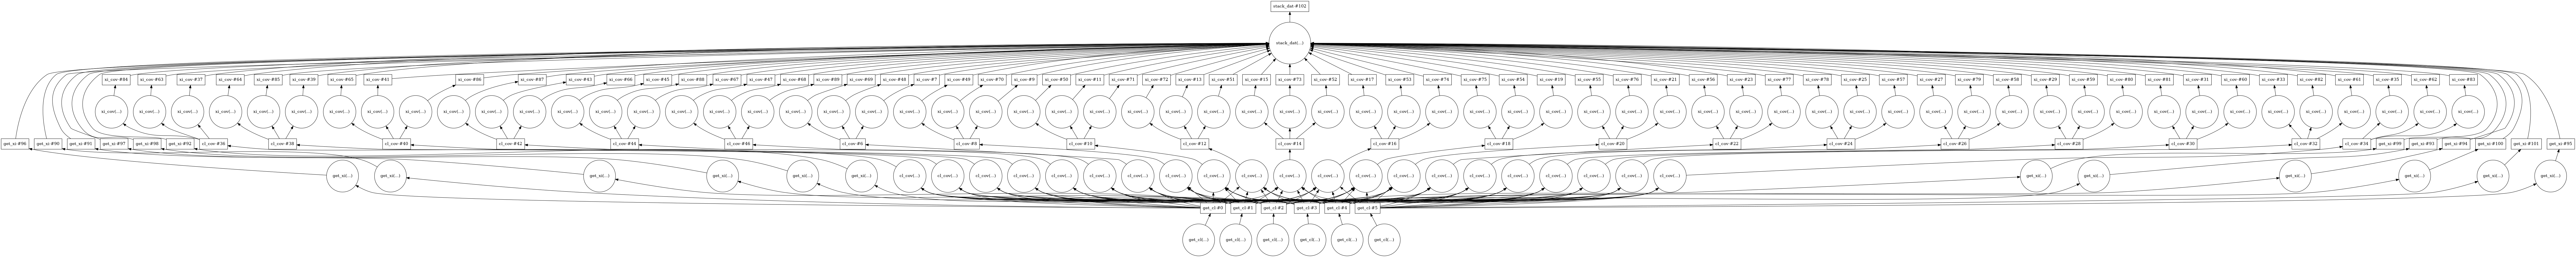

In [23]:
xiHG['stack'].visualize() #compute graph

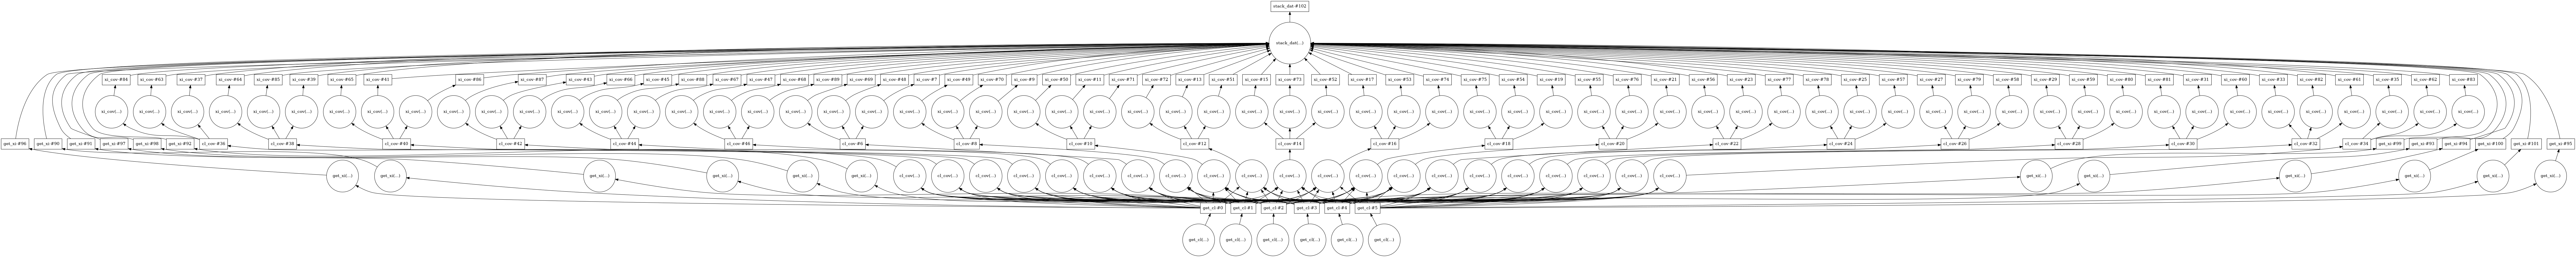

In [35]:
xiWG['stack'].visualize() #compute graph

In [ ]:
f=1
cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiW_inv=np.linalg.inv(xiW['cov']*f)
print (np.sqrt(np.dot(xiW['xi'],np.dot(cov_xiW_inv,xiW['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

In [ ]:
cc=XI_H.cov_utils
corrH=cc.corr_matrix(xiH['cov'])
pcolor(corrH,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Hankel')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])
title('Wigner')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W.cov_utils
corrWL=cc.corr_matrix(xiW_L['cov'])
pcolor(corrWL,vmin=-1,vmax=1,cmap='seismic')
title('Wigner')
show()

In [ ]:
corr=('shear','shear')

In [ ]:
m1m2=(2, 2, 2, -2)
i=0
j=0
cov_t=xiWG['cov'][corr+corr][m1m2][(i,j,i,j)].compute()
pcolor(cov_t['final'])
colorbar()
# print (cov_t)

In [ ]:
m1m2=(2,2)

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb.numpy()*1.0,(thb*xiHG['xi'][corr][m1m2][(i,j)].compute()).numpy(),
                 (thb*tc.sqrt(tc.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))).numpy(),fmt='^',label=(i,j))
        errorbar(thb.numpy()*1.03,(thb*xiWG_L['xi'][corr][m1m2][(i,j)].compute()).numpy(),
                 (thb*tc.sqrt(tc.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))).numpy(),fmt='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
        xi_plus = tc.tensor(ccl.correlation(ccl_cosmo, XI_W_L.l, cls, XI_W_L.HT.theta[m1m2]/d2r,corr_type='L+', method='FFTLog'),dtype=tc.double)
        xi_b=XI_W_L.binning.bin_1d(xi=xi_plus,bin_utils=XI_W_L.xi_bin_utils[m1m2])
        plot(thb.numpy(),(thb*xi_b).numpy())
        xscale('log')
#         yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
        show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
#         errorbar(thb,xiHG['xi'][corr][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
#         plot(XI_W_L.l,xiWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
#         plot(XI_W_L.l,clWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
#         xi_plus = ccl.correlation(ccl_cosmo, ell, cls, th,corr_type='L+', method='FFTLog')
#         plot(XI_W_L.l,cls)
        plot(XI_W_L.l,clWG_L['cl'][corr][(i,j)].compute()/cls)
        xscale('log')
#         yscale('log')
        hlines(1,2,1000)
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
#         show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiHG['xi'][corr][m1m2][(i,j)].compute(),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb, np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta \xi $')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiHG['xi'][corr][m1m2][(i,j)].compute()/np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$')
ylabel(r'$\xi/\delta \xi$')
legend()

In [ ]:
nbins=3

In [ ]:
corr=('shear','shear')
m1m2=(2,2)
for i in np.arange(nbins):
    j=i
    errorbar(thb*(1+i*0.05),(xiHG['xi'][corr][m1m2][(i,j)].compute()/xiWG['xi'][corr][m1m2][(i,j)].compute()-1),
                         np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/xiWG['xi'][corr][m1m2][(i,j)].compute(),
             fmt='o',label=(i,j)) 
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$|\xi_- ( {Hankel})/\xi_- ( {Wigner})-1|$')
hlines(1,0.1,10)
yscale('log')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/(np.diag(xiWG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta\xi_+(Hankel)/\delta\xi_+(Wigner)$')
hlines(1,0.1,10)
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/np.sqrt(np.diag(xiWG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta\xi(\ell_{max}\times2)/\delta\xi(W)$')
# hlines(1,0.1,10)
legend()

In [ ]:
m1m2

In [ ]:
for i in np.arange(nbins):
    j=i
    plot(thb,xiWG_L['xi'][corr][m1m2][(i,j)].compute()/xiWG['xi'][corr][m1m2][(i,j)].compute(),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi_+ (\ell_{max}\times2)/\xi_+ (W)$')
# hlines(1,0.1,10)
legend()

In [ ]:
crash

# Galaxy X Lensing Correlation function covariance

In [ ]:
import galaxy_utils
reload(galaxy_utils)
from galaxy_utils import *

In [ ]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [ ]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [ ]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=5  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
# nbins=3  # Number of tomographic bins
z_sigma=0.1
zg_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))


# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

SSV_cov=True
tidal_SSV=False

In [ ]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=1./60
th_max=10
n_th_bins=20
n_th=160
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th)
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [ ]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [ ]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
WT_kwargs={'l':l_W ,'theta':th*d2r ,'m1_m2':[(0,0),(0,2),(2,2),(2,-2)]}
# %time WTggl=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zg_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,HT=WTggl,
#               HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [ ]:
%time cl_Wggl=XI_W.cl_tomo(corrs=[corr_ll,corr_ggl,corr_gg])

In [ ]:
%time xiWggl=XI_W.xi_tomo(corrs=[corr_ll,corr_ggl,corr_gg])
%time xiW_ggl=xiWggl['stack'].compute()

In [ ]:
cl_Wggl['cl'][corr_ggl][(0,0)].compute().min()

In [ ]:
cl_Wggl['cl'].keys()

In [ ]:
cl_Wggl['cov'][corr_ggl+corr_ggl][(0,0,0,1)]['G1423'].compute().min()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),label=(i,j))
        plot(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),ls='--')
        xscale('log')
        yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(0,nbins):
        errorbar(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
nbins=5

In [ ]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW_ggl['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
x1=20.*nbins*(nbins+1)/2.
x2=20.*nbins*nbins
hlines(x1,0,len(corrW),lw=2)
vlines(x1,0,len(corrW),lw=2)
hlines(x1*2,0,len(corrW),lw=2)
vlines(x1*2,0,len(corrW),lw=2)
hlines(x1*2+x2,0,len(corrW),lw=2)
vlines(x1*2+x2,0,len(corrW),lw=2)
title('Wigner')
xticks([])
yticks([])
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
import healpy as hp
hp.nside2npix(1024)